In [1]:
import multiprocessing
import time
import numpy as np
from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit, Parameter
from qiskit import Aer, execute
from numpy.random import default_rng
import matplotlib.pyplot as plt

In [2]:
def one_step(dt, m=0.5, w=1., J=1., barrier=False):
    num_sites = system_size
    
    qc = QuantumCircuit(num_sites)
    
    # exp(-i dt Hzz)
    for iqr in range(1, num_sites - 1):
        phi = J * 0.5 * (2. * dt) * (num_sites - iqr - 1)
        for iql in range(iqr):
            qc.cx(iql, iqr)
            qc.p(phi, iqr)
            qc.cx(iql, iqr)
            
    if barrier:
        qc.barrier()
            
    # exp(-i dt Hpm)
    # Hpm = w sum (sigma+ sigma- + h.c.) = w sum h
    # h = 1/2 XX + 1/2 YY
    phi = w * 0.5 * (2. * dt)
    for iq in range(num_sites - 1):
        # exp(-i dt w/2 XX)
        qc.cx(iq, iq + 1)
        qc.rx(phi, iq)
        qc.cx(iq, iq + 1)
        # exp(-i dt w/2 YY)
        qc.cz(iq, iq + 1)
        qc.cx(iq, iq + 1)
        qc.rx(phi, iq)
        qc.cx(iq, iq + 1)
        qc.cz(iq, iq + 1)
        
    if barrier:
        qc.barrier()

    # exp(-i dt Hz1)
    phi = m * 0.5 * (2. * dt)
    for iq in range(num_sites):
        if iq % 2 == 0:
            qc.p(-phi, iq)
        else:
            qc.p(phi, iq)
            
    if barrier:
        qc.barrier()

    # exp(-i dt Hz2)
    for iq in range(num_sites - 1):
        phi = -J * 0.5 * (num_sites // 2 - (iq + 1) // 2) * (2. * dt)
        qc.p(phi, iq)
            
    if barrier:
        qc.barrier()
            
    return qc

In [3]:
def get_renyi_entropy_swaptest(circuit, subsystem):
    nq = circuit.num_qubits
    circ = QuantumCircuit(nq * 2 + 1, 1)
    circ = circ.compose(circuit, qubits=list(range(nq)))
    circ = circ.compose(circuit, qubits=list(range(nq, nq * 2)))

    # cswap only on the subsystem
    circ.h(nq * 2)
    for iq in subsystem:
        circ.cswap(nq * 2, iq, nq + iq)
    circ.h(nq * 2)
    circ.measure(nq * 2, 0)
    
    backend = Aer.get_backend('qasm_simulator')
    backend.set_options(method='statevector_gpu')
    shots = 2 ** 19
    job = execute(circ, backend, shots=shots)
    result = job.result()
    print(result.data(0)['counts'])
    zero_counts = result.data(0)['counts']['0x0']
    
    return zero_counts / shots * 2. - 1.

In [4]:
def get_renyi_entropy(circuit, subsystem):
    system_size = circuit.num_qubits
    subsystem_size = len(subsystem)
        
    # assuming subsystem is contiguous
    if min(subsystem) == 0:
        statevector = statevector.reshape((-1, 2 ** subsystem_size))
    elif max(subsystem) == system_size - 1:
        statevector = statevector.reshape((2 ** subsystem_size, -1))\
                    .transpose((1, 0))
    else:
        statevector = statevector.reshape((-1, 2 ** subsystem_size, 2 ** min(subsystem)))\
                    .transpose((0, 2, 1))\
                    .reshape((-1, 2 ** subsystem_size))

    # p_i p_j |<psi_i | psi_j>|^2
    # statevector components are unnormalized -> square(abs(statevector)) = p_i ||psi_i>|^2
    #purity = np.sum(np.square(np.abs(np.einsum('ik,jk->ij', np.conjugate(statevector), statevector)))) # by environment indices
    purity = np.sum(np.square(np.abs(np.einsum('ij,ik->jk', np.conjugate(statevector), statevector)))) # by subsystem indices
    
    return -np.log2(purity), statevector

In [5]:
def get_subsystem_probs(circuit):
#     backend = Aer.get_backend('statevector_simulator')
#     job = execute(circuit, backend)
#     result = job.result()
#     probs = np.square(np.abs(result.data()['statevector']))
    
    backend = Aer.get_backend('qasm_simulator')
    backend.set_options(method='statevector_gpu')
    circuit.measure_all()
    shots = 2 ** 16
    job = execute(circuit, backend, shots=2**16)
    result = job.result()
    
    probs = np.zeros(2 ** system_size, dtype=np.float)
    for hexidx, count in result.data(0)['counts'].items():
        probs[int(hexidx[:(system_size // 4) + 2], 16)] = count
    probs /= shots
        
    # take the subsystem from the center of the bitstring
    margin = 2 ** ((system_size - subsystem_size) // 2)
    probs = np.sum(probs.reshape((margin, 2 ** subsystem_size, margin)), axis=(0, 2))
    
    return probs

In [6]:
def get_electron_number_distribution(probs):
    result = np.zeros(subsystem_size + 1, dtype=np.float)
    for idx, prob in enumerate(probs):
        # up to subsystem_size == 8
        bitarray = np.unpackbits(np.array(idx, dtype=np.uint8))[-1:-subsystem_size - 1:-1]
        z = np.sum(1 - bitarray[0::2], dtype=np.int) - np.sum(bitarray[1::2], dtype=np.int) + (subsystem_size // 2)
        result[z] += prob
        
    return result

In [7]:
system_size = 26
subsystem = list(range(9, 17))
subsystem_size = len(subsystem)

m = 0.5
w = 1.
J = 1.

In [8]:
dt = np.pi / 16.
num_steps = 10

entropies = np.empty(num_steps + 1, dtype=np.float)
entropies[0] = 0.

circuit = QuantumCircuit(system_size)

# initial state = vacuum
for iq in range(0, system_size, 2):
    circuit.x(iq)

for istep in range(num_steps):
    start = time.time()
    circuit += one_step(dt)
    
    backend = Aer.get_backend('statevector_simulator')
    backend.set_options(method='statevector_gpu')
    job = execute(circuit, backend)
    result = job.result()
    statevector = result.data()['statevector']
    
    print(time.time() - start, 's to move one step')
        
    entropy, statevector = get_renyi_entropy(statevector, subsystem)
    entropies[istep + 1] = entropy

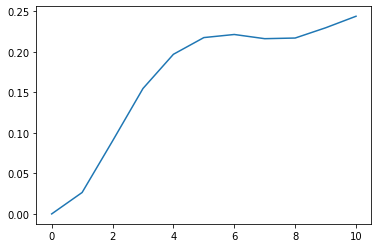

In [9]:
plt.plot(np.arange(num_steps + 1), entropies / subsystem_size)

In [19]:
probs = np.sum(np.square(np.abs(statevector)), axis=0)
indices = np.arange(2 ** subsystem_size, dtype=np.uint8).reshape((-1, 1))
bitarray = np.unpackbits(indices, axis=1)
electron_numbers = np.sum(1 - bitarray[:, 0::2], axis=1, dtype=np.int) - np.sum(bitarray[:, 1::2], axis=1, dtype=np.int)

dist = np.zeros(subsystem_size + 1)
for n in range(-subsystem_size // 2, subsystem_size // 2 + 1):
    idx = np.nonzero(electron_numbers == n)[0]
    dist[n + subsystem_size // 2] += np.sum(probs[idx])

[ 4  3  3  2  3  2  2  1  3  2  2  1  2  1  1  0  3  2  2  1  2  1  1  0
  2  1  1  0  1  0  0 -1  3  2  2  1  2  1  1  0  2  1  1  0  1  0  0 -1
  2  1  1  0  1  0  0 -1  1  0  0 -1  0 -1 -1 -2  3  2  2  1  2  1  1  0
  2  1  1  0  1  0  0 -1  2  1  1  0  1  0  0 -1  1  0  0 -1  0 -1 -1 -2
  2  1  1  0  1  0  0 -1  1  0  0 -1  0 -1 -1 -2  1  0  0 -1  0 -1 -1 -2
  0 -1 -1 -2 -1 -2 -2 -3  3  2  2  1  2  1  1  0  2  1  1  0  1  0  0 -1
  2  1  1  0  1  0  0 -1  1  0  0 -1  0 -1 -1 -2  2  1  1  0  1  0  0 -1
  1  0  0 -1  0 -1 -1 -2  1  0  0 -1  0 -1 -1 -2  0 -1 -1 -2 -1 -2 -2 -3
  2  1  1  0  1  0  0 -1  1  0  0 -1  0 -1 -1 -2  1  0  0 -1  0 -1 -1 -2
  0 -1 -1 -2 -1 -2 -2 -3  1  0  0 -1  0 -1 -1 -2  0 -1 -1 -2 -1 -2 -2 -3
  0 -1 -1 -2 -1 -2 -2 -3 -1 -2 -2 -3 -2 -3 -3 -4]


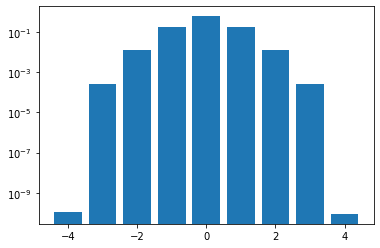

In [20]:
plt.bar(np.linspace(-(subsystem_size // 2), subsystem_size // 2, subsystem_size + 1), dist)
plt.yscale('log')